In [1]:
# coding: utf-8
get_ipython().magic(u'matplotlib notebook')
# %matplotlib notebook

import sys, math
# import numpy as np
import scipy
import diy
import autograd.numpy as np
from autograd.numpy import linalg as LA
from autograd import elementwise_grad as egrad

import mpl_toolkits.mplot3d.axes3d as axes3d
from matplotlib import pyplot as plt
from matplotlib import cm

plt.style.use(['seaborn-whitegrid'])
# plt.style.use(['ggplot'])
# plt.style.use(['classic'])
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "axes.labelcolor" : "b",
          "axes.edgecolor" : "b"}
plt.rcParams.update(params)

# --- set problem input parameters here ---
nSubDomainsX   = 2
nSubDomainsY   = 2
degree         = 3
analyticalFun  = 4
# ------------------------------------------
# Solver parameters
useAdditiveSchwartz = True
useDerivativeConstraints = 0

solverScheme   = 'L-BFGS-B' # [L-BFGS-B, TNC, SLSQP, COBYLA]
nControlPointsInput = 6#(3*degree + 1) #minimum number of control points
maxIterASM     = 2

maxAbsErr      = 1e-10
maxRelErr      = 1e-10
maxAdaptIter   = 3
# AdaptiveStrategy = 'extend'
AdaptiveStrategy = 'reset'
# ------------------------------------------

# Initialize DIY
w = diy.mpi.MPIComm()           # world

def plot3D(fig, Z, x=None, y=None):
    if x is None:
        x = np.arange(Z.shape[1])
    if y is None:
        y = np.arange(Z.shape[0])
    X, Y = np.meshgrid(x, y)
    print("Plot shapes: [x, y, z] = ", x.shape, y.shape, Z.shape)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
    fig.colorbar(surf)
    plt.show()


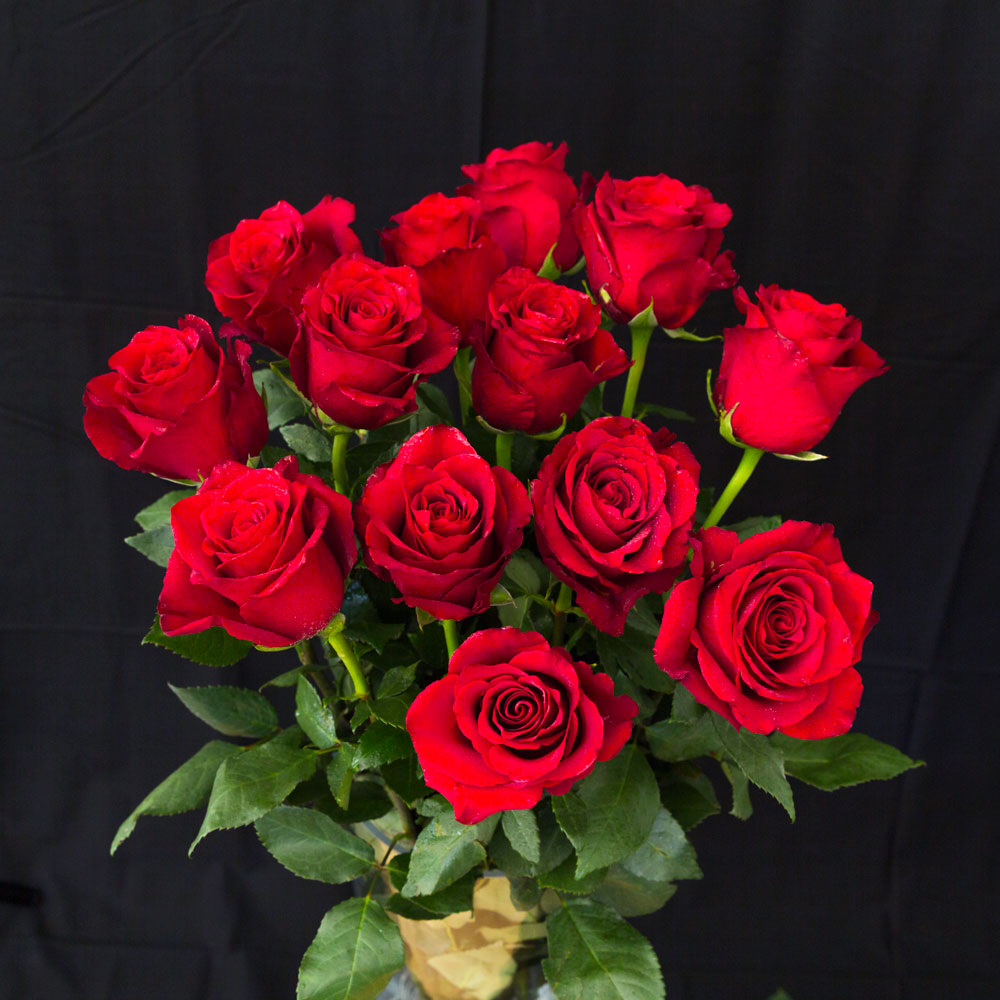

Image shape: (1000, 1000, 3) (1000, 1000)


NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

In [11]:
from scipy.ndimage import zoom

if analyticalFun == 1:
    nPointsX = 101
    nPointsY = 101
    scale    = 1
    shiftX   = 0
    shiftY   = 0
    Dmin     = -4.
    Dmax     = 4.

    x = np.linspace(Dmin, Dmax, nPointsX)
    y = np.linspace(Dmin, Dmax, nPointsY)
    X, Y = np.meshgrid(x+shiftX, y+shiftY)
    z = scale * np.sinc(np.sqrt(X**2 + Y**2))

elif analyticalFun == 2:
    nPointsX = 101
    nPointsY = 101
    scale    = 1
    shiftX   = 0
    shiftY   = 0
    Dmin     = 0
    Dmax     = math.pi

    x = np.linspace(Dmin, Dmax, nPointsX)
    y = np.linspace(Dmin, Dmax, nPointsY)
    X, Y = np.meshgrid(x+shiftX, y+shiftY)
    z = scale * np.sin(X) * np.sin(Y)

elif analyticalFun == 3:
    binFactor = 4.0
    z = np.fromfile("s3d_2D.raw", dtype=np.float64).reshape(540,704)
    #z = np.fromfile("nek5000.raw", dtype=np.float64).reshape(200,200)
#     z = zoom(z, 1./binFactor, order=4)
    print ("S3D shape:", z.shape)
    nPointsY = z.shape[0]
    nPointsX = z.shape[1]
    Dmin     = 0.
    Dmax     = 100.
    x = np.linspace(Dmin, Dmax, nPointsX)
    y = np.linspace(Dmin, Dmax, nPointsY)

else:
    from PIL import Image as PILImage

    def display_image(image_path):
        from IPython.display import Image 
        image = Image(filename=image_path)

        display(image)

    def display_image_obj(image_rgb):
#         from IPython.display import Image 
        image = PILImage.fromarray(image_rgb, 'RGB')

        display(image)

    def get_image(image_path):
        """Get a numpy array of an image so that one can access values[x][y]."""
        image = PILImage.open(image_path, 'r')

        width, height = image.size
        pixel_values = list(image.getdata())
        if image.mode == 'RGB':
            channels = 3
        elif image.mode == 'L':
            channels = 1
        else:
            print("Unknown mode: %s" % image.mode)
            return None
        pixel_values = np.array(pixel_values).reshape((width, height, channels))
        return image, pixel_values

    image_fname = 'roses.jpg' # 'shiva.jpg'
    display_image(image_fname)

    img, za = get_image(image_fname)
#     z = za[:,:,0]
    redChannel = za[:,:,0]
    greenChannel = za[:,:,1]
    blueChannel = za[:,:,2]
    z = 0.2989 * redChannel + 0.5870 * greenChannel + 0.1140 * blueChannel # Convert RGB to Graychannel
    print ("Image shape:", za.shape, z.shape)
    nPointsY = z.shape[0]
    nPointsX = z.shape[1]
    Dmin     = 0.
    Dmax     = 1
    x = np.linspace(Dmin, Dmax, nPointsX) 
    y = np.linspace(Dmin, Dmax, nPointsY)
#     print ("Image scale:", scale.shape)
#     ind = z < 100
#     z[ind] += 250
    plt.imshow(z, vmin=0, vmax=255)
    plt.show()



# if nPointsX % nSubDomainsX > 0 or nPointsY % nSubDomainsY > 0:
#     print ( "[ERROR]: The total number of points do not divide equally with subdomains" )
#     sys.exit(1)

fig = plt.figure()
zRange = z.max()-z.min()
plot3D(fig, z, x, y)


<IPython.core.display.Javascript object>


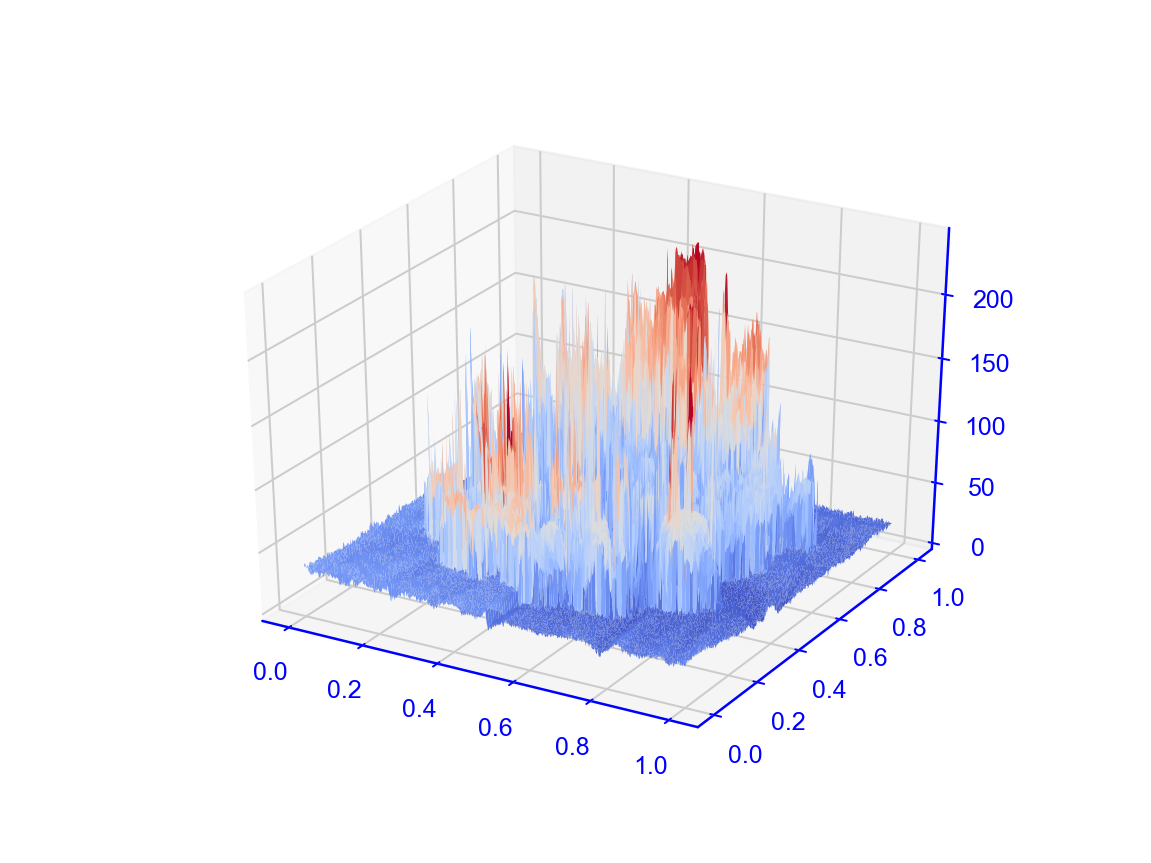

Subdomain 0:  [0 0 - 500 500] [0 0 - 500 500] [0 0 - 999 999]
Subdomain 1:  [500 0 - 999 500] [500 0 - 999 500] [0 0 - 999 999]
Subdomain 2:  [0 500 - 500 999] [0 500 - 500 999] [0 0 - 999 999]
Subdomain 3:  [500 500 - 999 999] [500 500 - 999 999] [0 0 - 999 999]
Rank: 0, Subdomain 3:   Bounds = [ 500 500  --  999 999 ]
Rank: 0, Subdomain 2:   Bounds = [ 0 500  --  500 999 ]
Rank: 0, Subdomain 1:   Bounds = [ 500 0  --  999 500 ]
Rank: 0, Subdomain 0:   Bounds = [ 0 0  --  500 500 ]
3 sending to 0: [3, 0] to direction (-1 -1)
3 sending to 1: [3, 1] to direction (0 -1)
3 sending to 2: [3, 2] to direction (-1 0)
2 sending to 0: [2, 0] to direction (0 -1)
2 sending to 1: [2, 1] to direction (1 -1)
2 sending to 3: [2, 3] to direction (1 0)
1 sending to 0: [1, 0] to direction (-1 0)
1 sending to 2: [1, 2] to direction (-1 1)
1 sending to 3: [1, 3] to direction (0 1)
0 sending to 1: [0, 1] to direction (1 0)
0 sending to 2: [0, 2] to direction (0 1)
0 sending to 3: [0, 3] to direction (1 1)


In [6]:
class InputBlock:

    def __init__(self, xb, xl, yl, zl, fig):
        self.xbounds = xb
        self.xl = xl
        self.yl = yl
        self.zl = zl
        self.fighnd = fig

    def show(self, cp):
        print("Rank: %d, Subdomain %d: " % (w.rank, cp.gid()), " Bounds = [", self.xbounds.min[0], self.xbounds.min[1], " -- ", self.xbounds.max[0], self.xbounds.max[1], "]")
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def plot(self, cp):
#         coeffs_x = getControlPoints(knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
        X, Y = np.meshgrid(self.xl, self.yl)
        ax = self.fighnd.gca(projection='3d')
        surf = ax.plot_surface(X, Y, self.zl, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)
        
#         fig.colorbar(surf)
        plt.show()

    def send(self, cp):
        link = cp.link()
        link.__class__ = diy._diy.RegularGridLink
        for i in range(len(link)):
            target = link.target(i)
            o = [cp.gid(), target.gid]
            dir = link.direction(i)
            print("%d sending to %d: %s to direction %s" % (cp.gid(), target.gid, o, dir))
            cp.enqueue(target, o) 

    def recv(self, cp):
        link = cp.link()
        link.__class__ = diy._diy.RegularGridLink
        for i in range(len(link)):
            gid = link.target(i).gid
            dir = link.direction(i)
            o = cp.dequeue(gid)
            print("%d received from %d: %s from direction %s" % (cp.gid(), gid, o, dir))


fig = plt.figure()
def add_input_block(gid, core, bounds, domain, link):
    print("Subdomain %d: " % gid, core, bounds, domain)
    minb = bounds.min
    maxb = bounds.max
    xlocal = x[minb[0]:maxb[0]+1]
    ylocal = y[minb[1]:maxb[1]+1]
    zlocal = z[minb[1]:maxb[1]+1, minb[0]:maxb[0]+1]
    mi.add(gid, InputBlock(core,xlocal,ylocal,zlocal,fig), link)

share_face = [True,True]
wrap = [False,False]
ghosts = [0,0]
divisions = [nSubDomainsX,nSubDomainsY]

# Initialize DIY
mi = diy.Master(w)         # master
domain_input = diy.DiscreteBounds([0, 0], [len(x)-1, len(y)-1])

# domain = diy.ContinuousBounds([min(x),min(y)], [max(x),max(y)])
# domain = diy.ContinuousBounds([x], [y])

d_input = diy.DiscreteDecomposer(2, domain_input, nSubDomainsX*nSubDomainsY, share_face, wrap, ghosts, divisions)
a_input = diy.ContiguousAssigner(w.size, nSubDomainsX*nSubDomainsY)
d_input.decompose(w.rank, a_input, add_input_block)

mi.foreach(InputBlock.show)

# plt.plot(x, y, 'b-', ms=5, label='Input')
# plot3D(fig, z, x, y)

mi.foreach(InputBlock.plot)

# Send receive data
mi.foreach(InputBlock.send)
mi.exchange(False)
mi.foreach(InputBlock.recv)


In [7]:
from scipy import linalg, matrix
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline, interp1d
from scipy.optimize import minimize, linprog
from scipy.linalg import svd
import timeit


EPS    = 1e-32
GTOL   = 1e-2
basis  = lambda u,p,T: ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else \
                    ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * basis(u,p-1,T)[:-1] + \
                    ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * basis(u,p-1,T)[1:]


def getControlPoints(knots, k):
    nCtrlPts = len(knots) - 1 - k
    cx       = np.zeros(nCtrlPts)
    for i in range(nCtrlPts):
        tsum = 0
        for j in range(1, k + 1):
            tsum += knots[i + j]
        cx[i] = float(tsum) / k
    return cx


def decode(P, W, degree, Nu, Nv):
    Nu = Nu[...,np.newaxis]
    Nv = Nv[:,np.newaxis]
    NN = []
    for ui in range(Nu.shape[0]):
        for vi in range(Nv.shape[0]):
          NN.append(Nu[ui]*Nv[vi])  
    NN = np.array(NN)

    decoded = np.tensordot(NN, P * W) / np.tensordot(NN, W)
    return decoded.reshape((Nu.shape[0], Nv.shape[0]))
#     RNx = N[0] * np.sum(W, axis=0)
#     RNx /= np.sum(RNx, axis=1)[:,np.newaxis]
#     RNy = N[1] * np.sum(W, axis=1)
#     RNy /= np.sum(RNy, axis=1)[:,np.newaxis]
#     return np.matmul(np.matmul(RNx, P), RNy.T)

def Error(P, W, z, degree, Nu, Nv):
    return decode(P, W, degree, Nu, Nv) - z

def RMSE(P, W, z, degree, Nu, Nv):
    E = Error(P, W, z, degree, Nu, Nv)
    return math.sqrt(np.sum(E**2)/len(E))

def NMaxError(P, W, z, degree, Nu, Nv):
    E = Error(P, W, z, degree, Nu, Nv)
    return np.abs(E).max()/zRange

def NMSE(P, W, z, degree, Nu, Nv):
    return (Error(P, W, z, degree, Nu, Nv)**2).mean()/zRange

def plotFit3D(fig, Nu, Nv, P, W, knotsU, knotsV, xl, yl, zl, degree, decoded=None, noDec=False):
    if decoded is None:
        decoded = decode(P, W, degree, Nu, Nv)
    X, Y = np.meshgrid(xl, yl)
    fig = plt.figure() if fig == None else fig
    ax = fig.gca(projection='3d')
    if not noDec:
        ax.plot_wireframe(X,Y, decoded, antialiased=True, color='g', lw=1, label='Decoded')
    surf = ax.plot_surface(X,Y, zl, antialiased=True, cmap=cm.coolwarm, alpha=0.75, label='Input')
    surf._facecolors2d=surf._facecolors3d
    surf._edgecolors2d=surf._edgecolors3d
    coeffs_y = getControlPoints(knotsU, degree) * (Dmax - Dmin) + Dmin
    coeffs_x = getControlPoints(knotsV, degree) * (Dmax - Dmin) + Dmin
    X, Y = np.meshgrid(coeffs_x, coeffs_y)
    ax.plot_wireframe(X,Y,P, linestyle='--', color='r', alpha=0.5, label='Control')
    ax.scatter(X,Y,P,color='r', s=(W/W.max())*50)
    ax.legend()
    plt.show()

def printFitStats(P, W, z, degree, Nu, Nv, decoded=None):
    print ("Ctrl points:", P.shape)
    E = Error(P, W, z, degree, Nu, Nv) if decoded is None else decoded-z
    E2 = E**2
    print ("Sum of squared error:", np.sum(E2))
    print ("Normalized mean squared error:", np.mean(E2/zRange))
    print ("Normalized max error:", np.abs(E).max()/zRange)

def L2LinfErrors(P, W, z, degree, Nu, Nv):

    E = Error(P, W, z, degree, Nu, Nv)
    LinfErr = np.abs(E).max()/zRange
    L2Err = math.sqrt(np.sum(E**2)/len(E))
    return [L2Err, LinfErr]

# # **Adaptive fitting per subdomain**

import collections

def rint(x):
    return int(round(x))

def toHomogeneous(P, W):
    return np.stack( ((P*W), W), axis=2)

def fromHomogeneous(PW):
    P = PW[...,0]
    W = PW[...,1]
    return P/W, W

def getSplits(T, U):
    t = T[degree:-degree]
    toSplit = [((t[:-1]<=u) * (u<=t[1:])).astype(np.float) for u in U]
    toSplit = np.array(toSplit).ravel()
    splitSize = t.shape[0]-1
    splits = []
    for i in range(0, toSplit.shape[0], splitSize):
        splits.append(toSplit[i:i+splitSize])
    toSplit = np.unique(np.array([np.unique(np.where(split))[0] for split in splits]))
    toSplit += degree
    return toSplit

def splitT(T, toSplit, nPoints):
    Tnew = []
    for ti,tval in enumerate(T):
        TnewVal = tval.copy()
        Tnew.append(TnewVal);
        if ti in toSplit:
            inc = (float(T[ti+1]-tval)/2.)
            if ((TnewVal+inc)*nPoints) - (TnewVal*nPoints) < 2:
                print ("Not enough input points to split", TnewVal, T[ti+1])
                toSplit.remove(ti)
                continue
            Tnew.append(TnewVal+inc)
    return np.array(Tnew)

def knotInsert(TU, TV, us, splitUs=True, r=1):
    toSplitU = set(getSplits(TU, us[...,0]))
    toSplitV = set(getSplits(TV, us[...,1]))
    return splitT(TU, toSplitU, nPointsX), splitT(TV, toSplitV, nPointsY), toSplitU, toSplitV
               
def knotRefine(P, W, TU, TV, U, V, zl, r=1, find_all=True, MAX_ERR = 1e-2, reuseE=None):
    NSE = reuseE
    if NSE is None:
        Nu = basis(U[np.newaxis,:],degree,TU[:,np.newaxis]).T
        Nv = basis(V[np.newaxis,:],degree,TV[:,np.newaxis]).T
        NSE = (Error(P, W, zl, degree, Nu, Nv)**2)/zRange
    NMSE = NSE.mean()
    if(NMSE<=MAX_ERR):
        return TU, TV, [], [], NSE, NMSE
    if find_all:
        rows,cols = np.where( NSE>=MAX_ERR )
        us = np.vstack( (U[rows] , V[cols]) ).T
    else:
        maxRow,maxCol = np.unravel_index(np.argmax(NSE), NSE.shape)
        NSE[maxRow,maxCol] = 0
        us = np.array([[U[maxRow],V[maxCol]]])
    TUnew,TVnew,Usplits,Vsplits=knotInsert(TU, TV, us, splitUs=find_all, r=r)
    return TUnew,TVnew,Usplits,Vsplits,NSE,NMSE

def insert_knot_u(P, W, T, u, k, degree, r=1, s=0):
    # Algorithm A5.3
    NP = np.array(P.shape)
    Q = np.zeros( (NP[0]+r, NP[1], 2) )
    # Initialize a local array of length p + 1
    R = np.zeros( (degree+1, 2) )
    PW = toHomogeneous(P, W)

    # Save the alphas
    alpha = [[0.0 for _ in range(r + 1)] for _ in range(degree - s)]
    for j in range(1, r + 1):
        L = k - degree + j
        for i in range(0, degree - j - s + 1):
            alpha[i][j] = (u - T[L + i]) / (T[i + k + 1] - T[L + i])

    # Update control points
    for row in range(0, NP[1]):
        for i in range(0, k - degree + 1):
            Q[i][row] = PW[i][row]
        for i in range(k - s, NP[0]):
            Q[i + r][row] = PW[i][row]
        # Load auxiliary control points
        for i in range(0, degree - s + 1):
            R[i] = (PW[k - degree + i][row]).copy()
        # Insert the knot r times
        for j in range(1, r + 1):
            L = k - degree + j
            for i in range(0, degree - j - s + 1):
                R[i][:] = [alpha[i][j] * elem2 + (1.0 - alpha[i][j]) * elem1
                           for elem1, elem2 in zip(R[i], R[i + 1])]
            Q[L][row] = R[0].copy()
            Q[k + r - j - s][row] = R[degree - j - s].copy()
        # Load the remaining control points
        L = k - degree + r
        for i in range(L + 1, k - s):
            Q[i][row] = R[i - L].copy()

    return Q

def insert_knot_v(P, W, T, u, k, degree, r=1, s=0):
    # Algorithm A5.3
    NP = np.array(P.shape)
    Q = np.zeros( (NP[0], NP[1]+r, 2) )
    # Initialize a local array of length p + 1
    R = np.zeros( (degree+1, 2) )
    PW = toHomogeneous(P, W)

    # Save the alphas
    alpha = [[0.0 for _ in range(r + 1)] for _ in range(degree - s)]
    for j in range(1, r + 1):
        L = k - degree + j
        for i in range(0, degree - j - s + 1):
            alpha[i][j] = (u - T[L + i]) / (T[i + k + 1] - T[L + i])

    # Update control points
    for col in range(0, NP[0]):
        for i in range(0, k - degree + 1):
            Q[col][i] = PW[col][i]
        for i in range(k - s, NP[1]):
            Q[col][i + r] = PW[col][i]
        # Load auxiliary control points
        for i in range(0, degree - s + 1):
            R[i] = (PW[col][k - degree + i]).copy()
        # Insert the knot r times
        for j in range(1, r + 1):
            L = k - degree + j
            for i in range(0, degree - j - s + 1):
                R[i][:] = [alpha[i][j] * elem2 + (1.0 - alpha[i][j]) * elem1
                           for elem1, elem2 in zip(R[i], R[i + 1])]
            Q[col][L] = R[0].copy()
            Q[col][k + r - j - s] = R[degree - j - s].copy()
        # Load the remaining control points
        L = k - degree + r
        for i in range(L + 1, k - s):
            Q[col][i] = R[i - L].copy()

    return Q
    
def deCasteljau(P, W, TU, TV, u, k, r=1):
    Qu = insert_knot_u(P, W, TU, u[0], k[0], degree, r)
    P,W= fromHomogeneous(Qu)
    Q  = insert_knot_v(P, W, TV, u[1], k[1], degree, r)
    P,W = fromHomogeneous(Q)
    return P,W

def lsqFitWithCons(Nu, Nv, W, z, degree, cons=None, continuity=0):
    def l2(P, W, z, degree, Nu, Ny):
        E = Error(P.reshape(W.shape), W, z, degree, Nu, Nv)
        return np.sum(E**2/len(E))
    res = minimize(l2, np.ones_like(W), method='SLSQP', args=(W, z, degree, Nu, Nv), 
                   constraints=cons,  options={'disp': True})
    return res.x, res.fun.tolist()



Subdomain 0:  0 0 500 500
Global Subdomain 0:  (1000,) (1000,) (1000, 1000)
Zlocal shape  (501, 501) (1000, 1000)
Subdomain 1:  500 0 999 500
Global Subdomain 1:  (1000,) (1000,) (1000, 1000)
Zlocal shape  (500, 501) (1000, 1000)
Subdomain 2:  0 500 500 999
Global Subdomain 2:  (1000,) (1000,) (1000, 1000)
Zlocal shape  (501, 500) (1000, 1000)
Subdomain 3:  500 500 999 999
Global Subdomain 3:  (1000,) (1000,) (1000, 1000)
Zlocal shape  (500, 500) (1000, 1000)
Rank: 0, Subdomain 3: Bounds = [500 - 999, 500 - 999]
Rank: 0, Subdomain 2: Bounds = [0 - 500, 500 - 999]
Rank: 0, Subdomain 1: Bounds = [500 - 999, 0 - 500]
Rank: 0, Subdomain 0: Bounds = [0 - 500, 0 - 500]

---- Starting Iteration: 0 ----
3 sending to 1: [0. 0. 0. 0. 0. 0.] to direction (0 -1)
3 sending to 2: [0. 0. 0. 0. 0. 0.] to direction (-1 0)
2 sending to 0: [0. 0. 0. 0. 0. 0.] to direction (0 -1)
2 sending to 3: [0. 0. 0. 0. 0. 0.] to direction (1 0)
1 sending to 0: [0. 0. 0. 0. 0. 0.] to direction (-1 0)
1 sending to 3: 

<IPython.core.display.Javascript object>


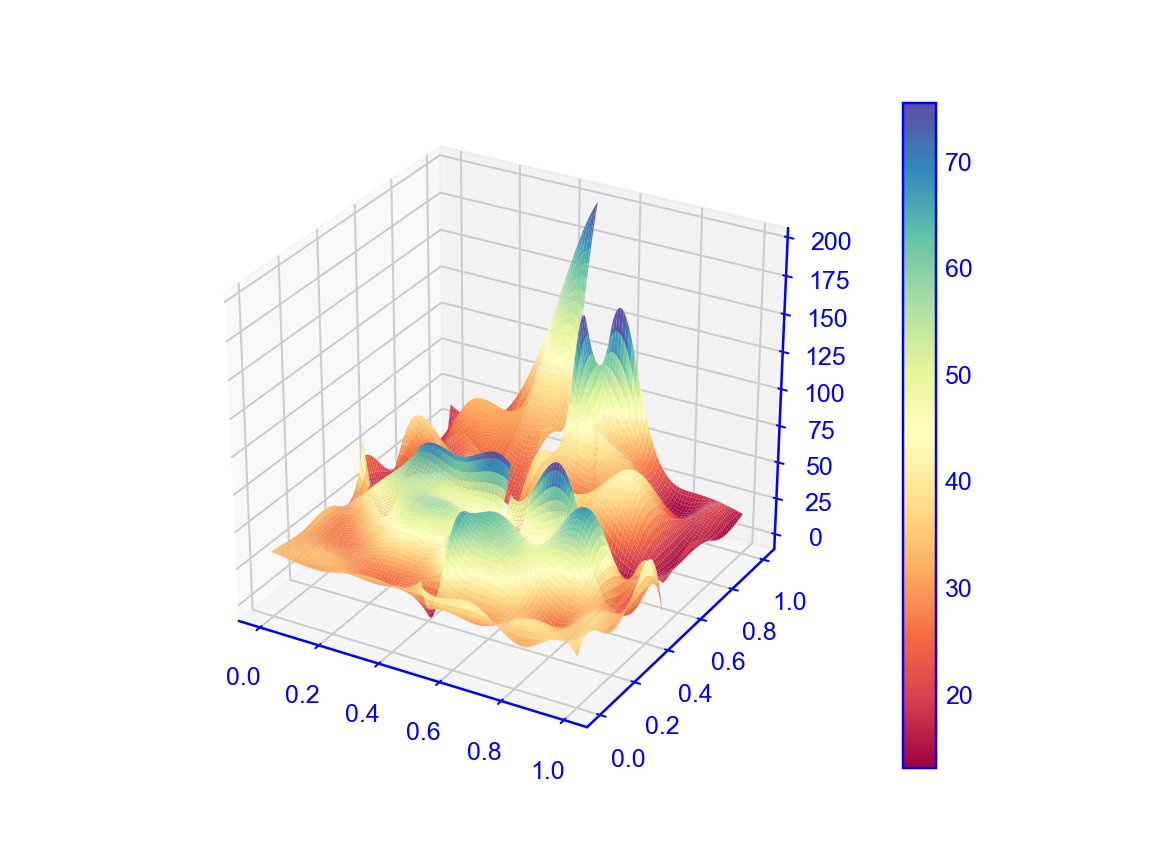

<IPython.core.display.Javascript object>


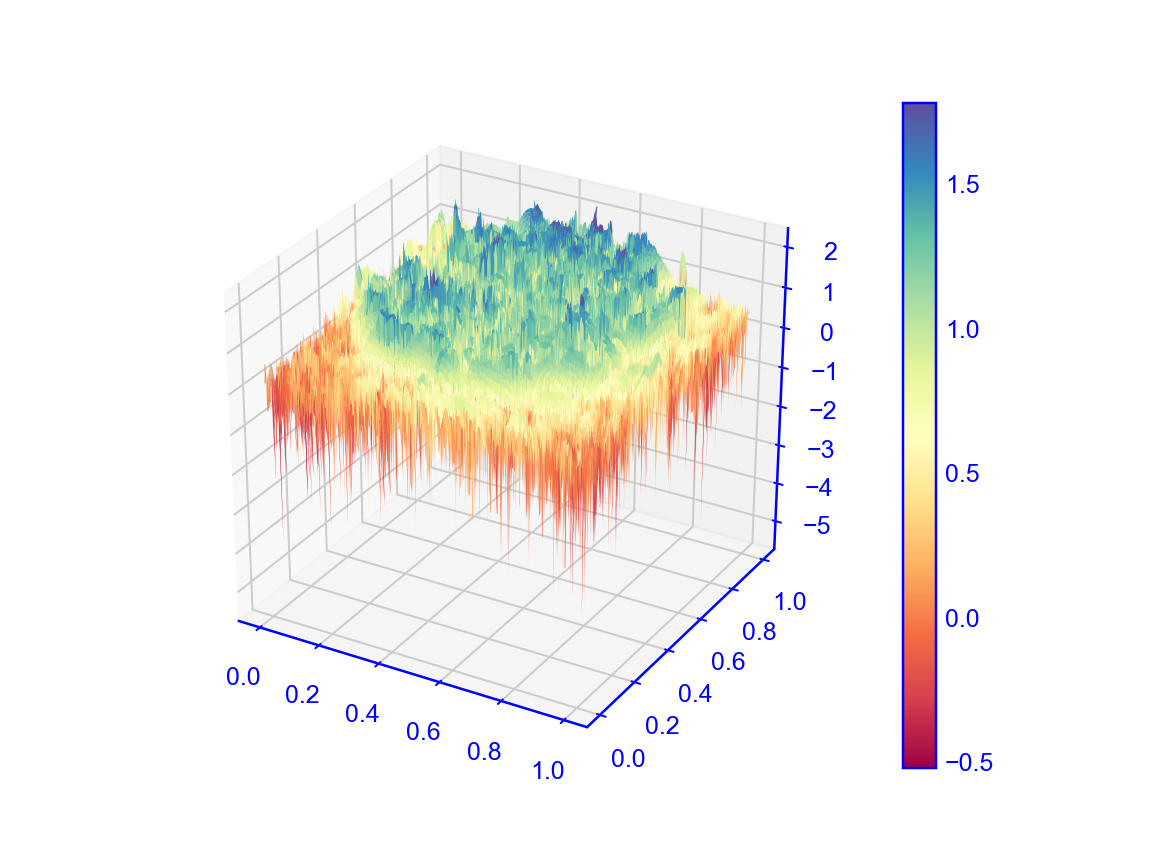


---- Starting Iteration: 1 ----
3 sending to 1: [ 31.85590395  42.18013032  89.74461511  13.99513353 215.93823954
  -1.5975404 ] to direction (0 -1)
3 sending to 2: [ -1.5975404  218.2957847   20.77892934  23.93345923  20.98955222
  17.050055  ] to direction (-1 0)
2 sending to 0: [39.84831941 -9.21584176 97.11244839 39.90477724 30.1355553  51.64577798] to direction (0 -1)
2 sending to 3: [39.84831941 30.65481125 53.4608116   0.11734481 44.02512085 23.53775193] to direction (1 0)
1 sending to 0: [ 38.75052286  31.18315291  26.73618401  95.20724716 183.31582176
 201.65440579] to direction (-1 0)
1 sending to 3: [ 48.19980554 -16.73232368 129.35855724  13.83721996 171.82073186
 201.65440579] to direction (0 1)
0 sending to 1: [33.69329105 32.87207284 26.44403433 41.97880744 30.69215539 44.29180274] to direction (1 0)
0 sending to 2: [ 44.29180274 -24.92641747 111.20814852   5.86225233  38.07844779
  71.6686205 ] to direction (0 1)
3 received from 1: [ 48.19980554 -16.73232368 129.358557

Iteration:  6
Residual =  2162224801.304803  and res_dec =  8121.298977670779  and constraint =  43.24449559430879
Iteration:  7
Residual =  2162224801.2964587  and res_dec =  8121.291761223533  and constraint =  43.24449559414212
[1] : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Errors-left:  [-1.17835675e-07  3.13653992e-08 -4.57119391e-08 -1.02217719e-06
 -3.17133302e-06 -3.78571832e-06 -8.09030413e+01]
Errors-top:  [ 8.09030450e+01 -4.01554454e-07  2.98030713e-07 -6.86900954e-07
 -1.08508548e-07  3.35643350e-07  4.58358862e-07]
	Decoded error:  43.97508475666441
Adaptive iteration  2 , at  43.97083546775205  maxError
-- Spatial Adaptivity: Before =  [7 7] , After =  [8 8]
1  - Applying the constrained solver.
Initial calculation
Iteration:  8
Residual =  3297693241.743935  and res_dec =  5265.986476826909  and constraint =  65.95386444311345
Iteration:  9
Residual =  2303307326.673026  and res_dec =  6030.722705258588  and constraint =  46.06614612743371
Iteration:  10
Resid

<IPython.core.display.Javascript object>


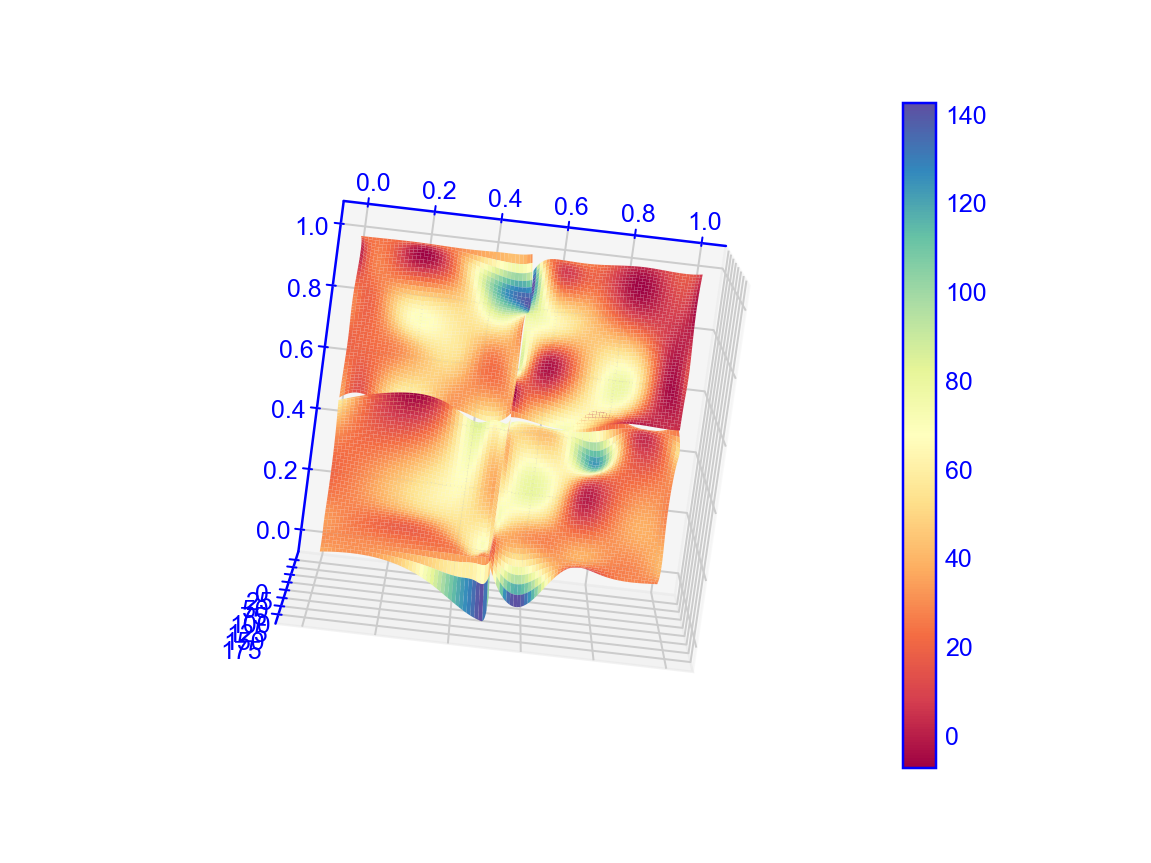

<IPython.core.display.Javascript object>


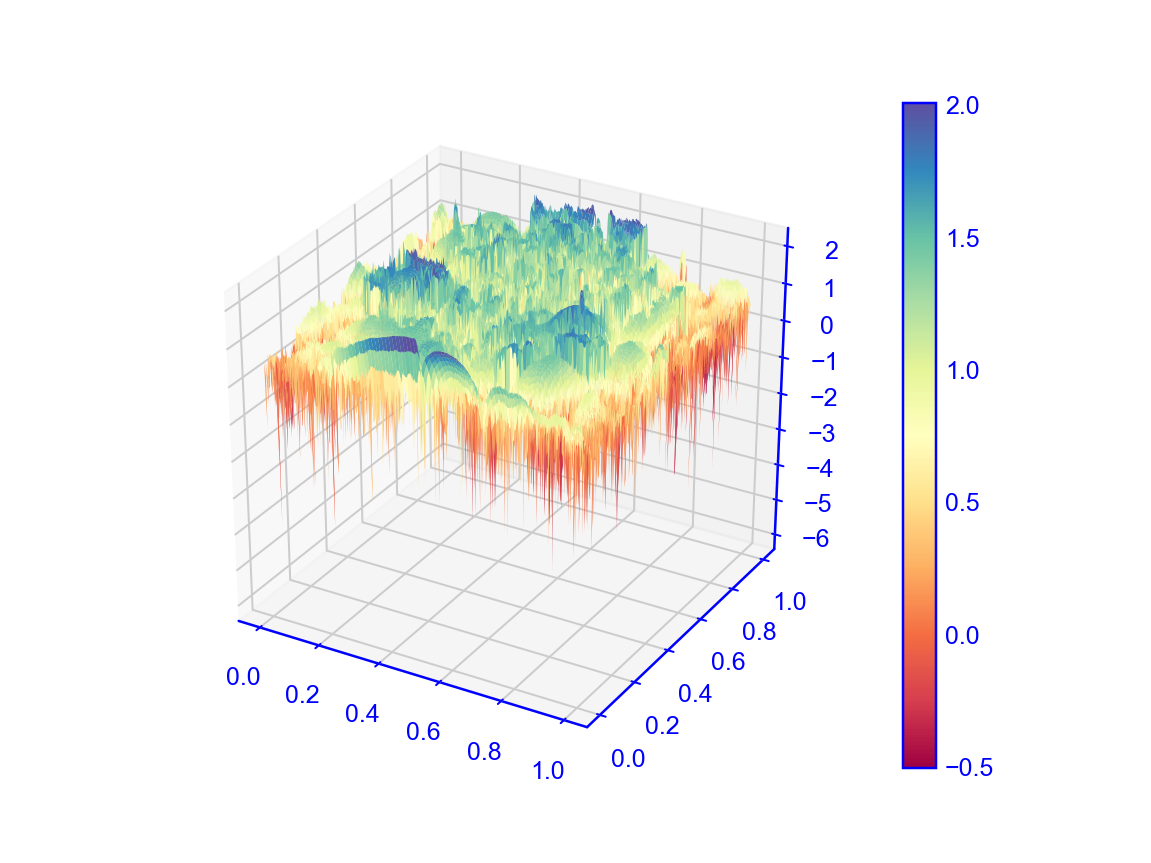

Domain:  4 Exact =  [[39.9153 44.0999 48.9362 ... 19.867  19.867  18.8671]
 [40.9583 44.2462 47.7406 ... 19.867  19.867  18.8671]
 [42.1692 43.9195 45.4634 ... 19.867  19.867  18.8671]
 ...
 [50.7255 46.883  42.8834 ... 20.1551 20.1551 20.1551]
 [48.1109 45.1112 41.1116 ... 20.1551 20.1551 20.1551]
 [45.2252 43.2254 39.6279 ... 20.1551 20.1551 20.1551]]
Domain:  4 Exact - Decoded =  [[ -8.28450554  -3.95449001   1.01434279 ...  -0.90670294  -0.80229293
   -1.69279559]
 [ -5.61072228  -2.23368723   1.33847072 ...  -0.93318376  -0.83426349
   -1.73047638]
 [ -2.80852956  -1.02390398   0.54441839 ...  -0.95875383  -0.86538626
   -1.767374  ]
 ...
 [-71.81196787 -72.56816503 -73.55403506 ...  -3.7830714   -3.41797763
   -3.04351307]
 [-73.54749191 -73.44968234 -74.42570516 ...  -3.94253362  -3.58204918
   -3.21231726]
 [-75.52616203 -74.41764691 -74.98213727 ...  -4.10337656  -3.74757523
   -3.38265192]]
Domain:  3 Exact =  [[24.8665 25.8664 25.9804 ... 28.1435 28.1435 29.1434]
 [24.8665 2

In [8]:

# from numpy import linalg as LA
from autograd.numpy import linalg as LA

def lsqFit1D(N, W, y, degree, constraints=None, continuity=0):
    if constraints is None or len(constraints)==0:
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        LHS = np.matmul(RN.T,RN)
        RHS = np.matmul(RN.T, y)
        return linalg.lstsq(LHS, RHS)[0]

def lsqFit(Nu, Nv, W, z, degree, use_cho=True, constraints=None, continuity=0):
    if constraints is None or len(constraints)==0:
        RNx = Nu * np.sum(W, axis=1)
        RNx /= np.sum(RNx, axis=1)[:,np.newaxis]
        RNy = Nv * np.sum(W, axis=0)
        RNy /= np.sum(RNy, axis=1)[:,np.newaxis]
        if use_cho:
            X = linalg.cho_solve(linalg.cho_factor(np.matmul(RNx.T,RNx)), RNx.T)
            Y = linalg.cho_solve(linalg.cho_factor(np.matmul(RNy.T,RNy)), RNy.T)
            return np.matmul(X, np.matmul(z, Y.T)), []
        else:
            NTNxInv = np.linalg.inv(np.matmul(RNx.T,RNx))
            NTNyInv = np.linalg.inv(np.matmul(RNy.T,RNy))
            NxTQNy = np.matmul(RNx.T, np.matmul(z, RNy))
            return np.matmul(NTNxInv, np.matmul(NxTQNy, NTNyInv)), []
#             NTNxInv = np.linalg.inv(np.matmul(RNx.T,RNx))
#             NTNyInv = np.linalg.inv(np.matmul(RNy.T,RNy))
#             NxTQNy = np.matmul(RNx.T, np.matmul(z, RNy))
#             return np.matmul(NTNxInv, np.matmul(NxTQNy, NTNyInv)), []
    else:
        return lsqFitWithCons(Nu, Nv, W, z, degree, cons=constraints, continuity=continuity)

#------------------------------------
# Let do the recursive iterations
# The variable `additiveSchwartz` controls whether we use
# Additive vs Multiplicative Schwartz scheme for DD resolution
####
class InputControlBlock:

    def __init__(self, nCP, xb, xl, yl, zl):
        self.nControlPoints = np.array([nCP, nCP])
        self.nControlPointSpans = np.array([nCP-1, nCP-1])
        self.nInternalKnotSpans = np.array([nCP - degree, nCP - degree])
        self.nPointsPerSubDX = len(xl)#int(nPointsX / nSubDomainsX)
        self.nPointsPerSubDY = len(yl)#int(nPointsY / nSubDomainsY)
        self.xbounds = xb
        self.xl = xl
        self.yl = yl
        self.zl = zl
        self.pAdaptive = np.zeros(self.nControlPoints)
        self.WAdaptive = np.ones(self.nControlPoints)
        self.knotsAdaptiveU = np.zeros(nCP+degree+1)
        self.knotsAdaptiveV = np.zeros(nCP+degree+1)
        self.U = []
        self.V = []
        self.Nu = []
        self.Nv = []
        self.Dmini = []
        self.Dmaxi = []
        self.leftconstraint = np.zeros(1)
        self.rightconstraint = np.zeros(1)
        self.topconstraint = np.zeros(1)
        self.bottomconstraint = np.zeros(1)
        self.figHnd = None
        self.figHndErr = None
        self.globalIterationNum = 0

    def show(self, cp):
        self.Dmini = np.array([min(self.xl), min(self.yl)])
        self.Dmaxi = np.array([max(self.xl), max(self.yl)])

        print("Rank: %d, Subdomain %d: Bounds = [%d - %d, %d - %d]" % (w.rank, cp.gid(), self.xbounds.min[0], self.xbounds.max[0], self.xbounds.min[1], self.xbounds.max[1]))
        # print("X/Y bounds (min/max) = ", self.Dmini, self.Dmaxi)
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def plot_control(self, cp):
#         print(w.rank, cp.gid(), self.core)
        # plotFit3D(NuA, NvA, PA, WA, knotsA_U, knotsA_V, x, y, z, degree, decoded=decoded)

#         self.figHnd = plt.figure()

#         self.Nu = basis(self.U[np.newaxis,:],degree,self.knotsAdaptiveU[:,np.newaxis]).T
#         self.Nv = basis(self.V[np.newaxis,:],degree,self.knotsAdaptiveV[:,np.newaxis]).T
#         decoded = E+z

        self.pMK = decode(self.pAdaptive, self.WAdaptive, degree, self.Nu, self.Nv)

        axHnd = self.figHnd.gca(projection='3d')

#         Xi, Yi = np.meshgrid(self.xl, self.yl)
        Xi, Yi = np.meshgrid(self.yl, self.xl)
#         surf = axHnd.plot_surface(Xi, Yi, self.zl, cmap=cm.coolwarm, antialiased=True, alpha=0.75, label='Input')
#         print('Plot shapes: ', Xi.shape, Yi.shape, self.pMK.shape)
        surf = axHnd.plot_surface(Xi, Yi, self.pMK, cmap=cm.Spectral, label='Decoded')
#         surf = axHnd.plot_surface(Xi, Yi, errorDecoded, cmap=cm.Spectral, label='Error')

        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d

        if cp.gid() == 0:
            self.figHnd.colorbar(surf)

        # Let us plot the control point data.
#         coeffs_y = getControlPoints(self.knotsAdaptiveV, degree)
#         coeffs_x = getControlPoints(self.knotsAdaptiveU, degree)
#         X, Y = np.meshgrid(coeffs_y, coeffs_x)
#         surf = axHnd.plot_surface(X, Y, self.pAdaptive, cmap=cm.coolwarm, antialiased=True, alpha=0.75, label='Input')
#         surf = axHnd.plot_wireframe(X, Y, self.pAdaptive, linestyle='--', color='r', alpha=0.5, label='Control')


#         plotFit3D(self.figHnd, self.Nu, self.Nv, self.pAdaptive, self.WAdaptive, self.knotsAdaptiveU, self.knotsAdaptiveV, 
#                   self.xl, self.yl, self.zl, degree, decoded=self.pMK, noDec=True)

#         plot3D(fig, self.pMK, coeffs_x, coeffs_y)
#         print("Shapes: [x, y, z] = ", self.xl.shape, self.yl.shape, self.zl.shape)
#         plotFit3D(fig, NuA, NvA, self.pAdaptive, self.WAdaptive, self.knotsAdaptiveU, self.knotsAdaptiveV,
#                  self.xl, self.yl, self.zl, degree, decoded=None)

    
    def plot_error(self, cp):

        self.pMK = decode(self.pAdaptive, self.WAdaptive, degree, self.Nu, self.Nv)
        errorDecoded = self.zl - self.pMK
#         print ("zl = ", self.zl)
#         print ("Decoded = ", self.pMK)

        axHnd = self.figHndErr.gca(projection='3d')

        Xi, Yi = np.meshgrid(self.yl, self.xl)
#         surf = axHnd.plot_surface(Xi, Yi, errorDecoded, cmap=cm.Spectral, label='Error')
        surf = axHnd.plot_surface(Xi, Yi, np.log10(np.abs(errorDecoded)), cmap=cm.Spectral, label='Error')

        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        
        if cp.gid() == 0:
            self.figHndErr.colorbar(surf)
#             axHnd.legend()

    def set_fig_handles(self, cp, fig=None, figerr=None):
        self.figHnd = fig
        self.figHndErr = figerr
        
    def print_solution(self, cp):
#         self.pMK = decode(self.pAdaptive, self.WAdaptive, degree, self.Nu, self.Nv)
#         errorDecoded = self.zl - self.pMK

        print("Domain: ", cp.gid()+1, "Exact = ", self.zl)
        print("Domain: ", cp.gid()+1, "Exact - Decoded = ", self.zl - self.pMK)

    def send(self, cp):
        link = cp.link()
        for i in range(len(link)):
            target = link.target(i)
            o = np.zeros(1)
            if len(self.pAdaptive):
                dir = link.direction(i)
                if dir[0] == 0 and dir[1] == 0:
                    continue;

                # ONLY consider coupling through faces and not through verties
                # This means either dir[0] or dir[1] has to be "0" for subdomain coupling to be active
                # Hence we only consider 4 neighbor cases, instead of 8.
                if dir[0] == 0: # target is coupled in Y-direction
                    if dir[1] > 0: # target block is above current subdomain
                        o = np.array(self.pAdaptive[:, -1])
                    else: # target block is below current subdomain
                        o = np.array(self.pAdaptive[:, 0])
                    
                if dir[1] == 0: # target is coupled in Y-direction
                    if dir[0] > 0: # target block is to the right of current subdomain
                        o = np.array(self.pAdaptive[0, :])
                    else: # target block is to the left of current subdomain
                        o = np.array(self.pAdaptive[-1, :])

            if len(o) > 1:
                print("%d sending to %d: %s to direction %s" % (cp.gid(), target.gid, o, dir))
            cp.enqueue(target, o)

    def recv(self, cp):
        link = cp.link()
        for i in range(len(link)):
            tgid = link.target(i).gid
            o = cp.dequeue(tgid)
            if len(o) == 1:
                continue

            dir = link.direction(i)
            print("%d received from %d: %s from direction %s" % (cp.gid(), tgid, o, dir))

            # ONLY consider coupling through faces and not through verties
            # This means either dir[0] or dir[1] has to be "0" for subdomain coupling to be active
            # Hence we only consider 4 neighbor cases, instead of 8.
            if dir[0] == 0 and dir[1] == 0:
                continue;
            if dir[0] == 0: # target is coupled in Y-direction
                if dir[1] > 0: # target block is above current subdomain
                    self.topconstraint = np.array(o[:]) if len(o) > 1 else []
                else: # target block is below current subdomain
                    self.bottomconstraint = np.array(o[:]) if len(o) > 1 else []

            if dir[1] == 0: # target is coupled in Y-direction
                if dir[0] > 0: # target block is above current subdomain
                    self.leftconstraint = np.array(o[:]) if len(o) > 1 else []
                else: # target block is below current subdomain
                    self.rightconstraint = np.array(o[:]) if len(o) > 1 else []


    def LSQFit_Constrained(self, idom, W, degree, constraintsAll=None, useDerivatives=0, solver='SLSQP'):

        constraints = None
        solution = []
        if constraintsAll is not None:
            constraints = constraintsAll['P'][:,:].reshape(W.shape)
            knotsAllU = constraintsAll['Tu']
            knotsAllV = constraintsAll['Tv']
            weightsAll = constraintsAll['W']
            left = constraintsAll['left']
            right = constraintsAll['right']
            top = constraintsAll['top']
            bottom = constraintsAll['bottom']
        else:
            print ('Constraints are all null. Solving unconstrained.')

        def ComputeL2Error(P, W, degree):
            E = Error(P.reshape(W.shape), W, self.zl, degree, self.Nu, self.Nv)
    #         return LA.norm(E, np.inf)
            return LA.norm(E, 'fro')

        cons = []
        if useDerivatives >= 0 and constraints is not None and len(constraints) > 0:
            if len(left) > 1:
    #                 cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x[:,:].reshape(W.shape))[0,:] - 0.5 * ( constraints[0,:] + left ) ]) } )
                cons.append( {'type': 'eq', 'fun' : lambda x: np.sum(((x.reshape(W.shape))[0,:] - 0.5 * ( constraints[0,:] + left[:] ) )**2) } )
#                 for indx in range(len(left)):
#                     print('Left constraints: ', (constraints[0,indx]),  ( left[indx] ) )
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[0,indx] - 0.5 * ( constraints[0,indx] + left[indx] ) ]) } )
            if len(right) > 1:
    #                 cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x[:,:].reshape(W.shape))[-1,:] - 0.5 * ( constraints[-1,:] + right ) ])} )
                cons.append( {'type': 'eq', 'fun' : lambda x: np.sum(((x.reshape(W.shape))[-1,:] - 0.5 * ( constraints[-1,:] + right[:] ) )**2) } )
#                 for indx in range(len(right)):
#                     print('Right constraints: ', (constraints[-1,indx]), ( right[indx] ) )
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[-1,indx] - 0.5 * ( constraints[-1,indx] + right[indx] ) ])} )

            if len(top) > 1:
    #                 cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[:,-1] - 0.5 * ( constraints[:,-1] + top ) ])} )
                cons.append( {'type': 'eq', 'fun' : lambda x: np.sum(((x.reshape(W.shape))[:,-1] - 0.5 * ( constraints[:,-1] + top[:] ) )**2) } )
#                 for indx in range(len(top)):
#                     print('Top constraints: ', (constraints[indx,-1]), ( top[indx] ) )
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[indx,-1] - 0.5 * ( constraints[indx,-1] + top[indx] ) ])} )
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[indx,-1] - ( top[indx] ) ])} )
            if len(bottom) > 1:
    #                 cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[:,0] - 0.5 * ( constraints[:,0] + bottom ) ])} )
                cons.append( {'type': 'eq', 'fun' : lambda x: np.sum(((x.reshape(W.shape))[:,0] - 0.5 * ( constraints[:,0] + bottom[:] ) )**2) } )
#                 for indx in range(len(bottom)):
#                     print('Bottom constraints: ', (constraints[indx,0]), ( bottom[indx] ) )
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[indx,0] - 0.5 * ( constraints[indx,0] + bottom[indx] ) ])} )
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ (x.reshape(W.shape))[indx,0] - ( bottom[indx] ) ])} )

            initSol = constraints[:,:].reshape(W.shape)
    #         initSol = np.ones_like(W)

    #             E = np.sum(Error(initSol, W, ysl, U, t, degree)**2)
            res = minimize(ComputeL2Error, x0=initSol, method=solver, args=(W, degree),
                           constraints=cons, #x0=initSol,
                           options={'disp': True, 'ftol': 1e-10, 'iprint': 4})
            print ('[%d] : %s' % (idom, res.message))
            solution = res.x
        else:

            solution,_ = lsqFit(self.Nu, self.Nv, W, self.zl, degree)
    #             res = minimize(ComputeL2Error, x0=np.ones_like(W), method='SLSQP', args=(W, degree),
    #                            options={'disp': True, 'ftol': 1e-10})
    #             print ('[%d] : %s' % (idom, res.message))
    #             solution = res.x


        return solution.reshape(W.shape)


    def LSQFit_NonlinearOptimize(self, idom, W, degree, constraintsAll=None, useDerivatives=0, solver='L-BFGS-B'):

        from scipy.optimize import root, anderson, newton_krylov#, BroydenFirst, KrylovJacobian

        # Initialize relevant data
        constraints = None
        jacobian_const = None
        solution = []

        # Compute the residual as sum of two components
        # 1. The decoded error evaluated at P
        # 2. A penalized domain boundary constraint component
        def residual(Pin, verbose=False):
            bc_penalty = 1e8
            norm_type = 2#np.inf
            
            P = Pin.reshape(W.shape)

            Nu = self.Nu[...,np.newaxis]
            Nv = self.Nv[:,np.newaxis]
            NN = []
            for ui in range(Nu.shape[0]):
                for vi in range(Nv.shape[0]):
                  NN.append(Nu[ui]*Nv[vi])  
            NN = np.array(NN)

            decoded = np.tensordot(NN, P * W) / np.tensordot(NN, W)

            # Residuals are in the decoded space - so direct way to constrain the boundary data
            res_dec = ( decoded.reshape(Nu.shape[0],Nv.shape[0]) - self.zl )
#             res1 = np.dot(res_dec, self.Nv)
#             residual = np.dot(self.Nu.T, res1).reshape(self.Nu.shape[1]*self.Nv.shape[1])

            residual = res_dec.reshape(self.Nu.shape[0]*self.Nv.shape[0])

            constraintRes = 0
            if constraints is not None and len(constraints) > 0:
                if len(left) > 1:
#                     print('Left Shapes: ', res.shape, res.reshape(W.shape)[0,:].shape, ( (P.reshape(W.shape))[0,:] - left[:] ).shape)
                    constraintRes += np.sum( ( (P.reshape(W.shape))[0,:] - left[:] )**2 ) / len(left)
                if len(right) > 1:
#                     print('Right Shapes: ', res.shape, res.reshape(W.shape)[-1,:].shape, ((P.reshape(W.shape))[-1,:] - right[:]).shape)
                    constraintRes += np.sum( ( (P.reshape(W.shape))[-1,:] - right[:] )**2 ) / len(right)
                if len(top) > 1:
                    constraintRes += np.sum( ( (P.reshape(W.shape))[:,-1] - top[:] )**2 ) / len(top)
                if len(bottom) > 1:
                    constraintRes += np.sum( ( (P.reshape(W.shape))[:,0] - bottom[:] )**2 ) / len(bottom)

            alpha = bc_penalty * 0.5
            res = np.sqrt(np.sum(residual**2)/len(residual)) + (alpha * np.sqrt(constraintRes))
#             res = LA.norm(residual, norm_type) + (alpha * np.sqrt(constraintRes))

            if verbose:
                print('Residual = ', res, ' and res_dec = ', LA.norm(res_dec, norm_type), ' and constraint = ', np.sqrt(constraintRes))

            return res

        def print_iterate(P):

            print('Iteration: ', self.globalIterationNum)
            res = residual(P, verbose=True)
            self.globalIterationNum += 1

        # Use automatic-differentiation to compute the Jacobian value for minimizer
        def jacobian(P):
#             if jacobian_const is None:
#                 jacobian = egrad(residual)(P)
#             else:
            jacobian = egrad(residual)(P)
#                 jacobian = jacobian_const
#             print('Jacobian = ', jacobian.shape)
            return jacobian

        if constraintsAll is not None:
            constraints = constraintsAll['P'][:,:].reshape(W.shape)
            knotsAllU = constraintsAll['Tu']
            knotsAllV = constraintsAll['Tv']
            weightsAll = constraintsAll['W']
            left = constraintsAll['left']
            right = constraintsAll['right']
            top = constraintsAll['top']
            bottom = constraintsAll['bottom']
            initSol = constraints[:,:]
#             jacobian_const = egrad(residual)(initSol)

        else:
            print ('Constraints are all null. Solving unconstrained.')
            initSol = np.ones_like(W)

        # Now invoke the solver and compute the constrained solution
        if constraints is None:
            solution,_ = lsqFit(self.Nu, self.Nv, W, self.zl, degree)
            solution = solution.reshape(W.shape)
        else:
            print('Initial calculation')
            print_iterate(initSol)
            res = minimize(residual, x0=initSol, method=solver, #'SLSQP', #'L-BFGS-B', #'TNC', 
                           jac=jacobian,
                           callback=print_iterate,
                           options={'disp': True, 'ftol': 1e-10})
            print ('[%d] : %s' % (idom, res.message))
            solution = res.x.reshape(W.shape)

#             jac = BroydenFirst()
#             kjac = KrylovJacobian(inner_M=jac.inverse)
#             solution = newton_krylov(residual, initSol, verbose=True, jac=kjac)
#             solution = res.x

        return solution


    def interpolate(self, P, knots, tnew):

        r = 1
        knotsnew = self.interpolate_knots(knots, tnew)
        # print (knotsnew.shape[0]-degree-1, useDerivativeConstraints+1)
        Pnew = np.zeros([knotsnew.shape[0]-degree-1, useDerivativeConstraints+1])
        for col in range(useDerivativeConstraints+1):
            Pnew[:,col], knotsnew = self.interpolate_private(P[:,col], knots, tnew)

        return Pnew, knotsnew


    def adaptive(self, iSubDom, xl, yl, zl, strategy='extend', weighted=False, 
                 r=1, MAX_ERR=1e-2, MAX_ITER=5, 
                 split_all=False, 
                 decodedError=None):

        from scipy.interpolate import Rbf
        
        disableAdaptivity = False

        start_time = timeit.default_timer()
        k = []
        r = min(r,degree) #multiplicity can not be larger than degree
        reuseE = (decodedError)/zRange if decodedError is not None else None

        splitIndeces = []
        r = min(r,degree) #multiplicity can not be larger than degree

        Tu = self.knotsAdaptiveU[:]
        Tv = self.knotsAdaptiveV[:]
        P = self.pAdaptive[:,:]
        W = self.WAdaptive[:,:]

        if (np.sum(P) == 0 and len(P) > 0) or len(P) == 0:
            self.Nu = basis(self.U[np.newaxis,:],degree,Tu[:,np.newaxis]).T
            self.Nv = basis(self.V[np.newaxis,:],degree,Tv[:,np.newaxis]).T
            #W = np.ones(self.nControlPoints)
            print(iSubDom, " - Applying the unconstrained solver.")
            print(self.Nu.shape, self.Nv.shape, self.zl.shape)
            P,_ = lsqFit(self.Nu, self.Nv, W, self.zl, degree)
#             print('Current P = ', P)
            decodedE = decode(P, W, degree, self.Nu, self.Nv) #- self.zl
#             print ('Local diff = ', self.zl-decodedE)
            MAX_ITER = 0

        iteration = 0
        globalIterationNum = 0
        for iteration in range(MAX_ITER):
            fev = 0
            if disableAdaptivity:
                
                interface_constraints_obj = dict()
                interface_constraints_obj['P']=P[:,:]
                interface_constraints_obj['W']=W[:,:]
                interface_constraints_obj['Tu']=Tu[:]
                interface_constraints_obj['Tv']=Tv[:]
                interface_constraints_obj['left'] = self.leftconstraint[:]
                interface_constraints_obj['right'] = self.rightconstraint[:]
                interface_constraints_obj['top'] = self.topconstraint[:]
                interface_constraints_obj['bottom'] = self.bottomconstraint[:]

                print(iSubDom, " - Applying the constrained solver.")
#                 P = self.LSQFit_Constrained(iSubDom, W, degree, 
#                                        interface_constraints_obj, 
#                                        useDerivativeConstraints, 'SLSQP')
                
                P = self.LSQFit_NonlinearOptimize(iSubDom, W, degree, 
                                       interface_constraints_obj, 
                                       useDerivativeConstraints, solver=solverScheme)
                
                P = P.reshape(W.shape)
    
#                 print('Current P = ', P)
#                 print('Constraint shapes: ', self.leftconstraint.shape, self.rightconstraint.shape, self.topconstraint.shape, self.bottomconstraint.shape)
                if len(self.leftconstraint) > 1:
                    print('Errors-left: ', P[0,:]-self.leftconstraint[:])
                if len(self.rightconstraint) > 1:
                    print('Errors-right: ', P[-1,:]-self.rightconstraint[:])
                if len(self.topconstraint) > 1:
                    print('Errors-top: ', P[:,-1]-self.topconstraint[:])
                if len(self.bottomconstraint) > 1:
                    print('Errors-bottom: ', P[:,0]-self.bottomconstraint[:])

#                 print("P: ", P)
#                 print("Left, Right: ", leftconstraint_projected[:], rightconstraint_projected[:])
#                 print("Top, Bottom: ", self.topconstraint[:], self.bottomconstraint[:])

            else:
                Tunew,Tvnew,Usplits,Vsplits,E,maxE = knotRefine(P, W, Tu, Tv, self.U, self.V, self.zl, r, 
                                                                reuseE=reuseE, MAX_ERR=MAX_ERR, 
                                                                find_all=split_all)
            
                maxE = LA.norm(E,'fro')
#                 maxE = LA.norm(E,np.inf)
                print("Adaptive iteration ", iteration+1, ", at ", maxE, " maxError")

                if (len(Tu)==len(Tunew) and len(Tv)==len(Tvnew)) or \
                    len(Tu)-degree-1 > self.nPointsPerSubDX or \
                    len(Tv)-degree-1 > self.nPointsPerSubDY:
    #                 print ("Nothing more to refine: E = ", E)
                    reuseE = E
                    break

                if len(Usplits)==0 or len(Vsplits)==0:
                    if (maxE>MAX_ERR):
    #                     print ("Max error hit: E = ", E)
                        reuseE = E
                        continue

                if(maxE<=MAX_ERR):
                    k = [-1, -1]
                    print ("Adaptive done in %d iterations at %e maxError"%(iteration+1,maxE))
                    break

                Tunew = np.sort(Tunew)
                Tvnew = np.sort(Tvnew)

                self.Nu = basis(self.U[np.newaxis,:],degree,Tunew[:,np.newaxis]).T
                self.Nv = basis(self.V[np.newaxis,:],degree,Tvnew[:,np.newaxis]).T

                nControlPointsPrev = self.nControlPoints
                self.nControlPoints = np.array([Tunew.shape[0]-1-degree, Tvnew.shape[0]-1-degree])
                self.nControlPointSpans = self.nControlPoints - 1
                self.nInternalKnotSpans = self.nControlPoints - degree

                print('-- Spatial Adaptivity: Before = ', nControlPointsPrev, ', After = ', self.nControlPoints)

                if strategy == 'extend' and not split_all:   #only use when coupled with a solver
                    k = [Usplits.pop(),Vsplits.pop()] #if reuseE is None else [-1,-1]
                    u = np.array([Tunew[k[0]+1],Tvnew[k[1]+1]])
                    print(iSubDom, " - Applying the deCasteljau solver")
                    P,W = deCasteljau(P, W, Tu, Tv, u, k, r)

                elif strategy == 'reset':

                    W = np.ones( self.nControlPoints )

                    # Need to compute a projection from [P, Tu, Tv] to [Pnew, Tunew, Tvnew]
                    coeffs_x1 = getControlPoints(Tu, degree)
                    coeffs_y1 = getControlPoints(Tv, degree)
                    Xi, Yi = np.meshgrid(coeffs_x1, coeffs_y1)

                    coeffs_x2 = getControlPoints(Tunew, degree)
                    coeffs_y2 = getControlPoints(Tvnew, degree)
                    Xi2, Yi2 = np.meshgrid(coeffs_x2, coeffs_y2)

                    rbfi = Rbf(Xi, Yi, P.reshape(len(P)**2), function='cubic')  # radial basis function interpolator instance
                    Pnew = rbfi(Xi2, Yi2).reshape(W.shape)   # interpolated values

#                     print('proj shapes: ', coeffs_x1.shape, coeffs_y1.shape, coeffs_x2.shape, coeffs_y2.shape, 
#                           self.leftconstraint.shape, self.rightconstraint.shape, self.topconstraint.shape, self.bottomconstraint.shape)

                    # Create a projection for also the solution vector along subdomain boundaries
                    if len(self.leftconstraint) > 1:
                        rbfL = Rbf(coeffs_y1, self.leftconstraint, function='cubic')
                        self.leftconstraint = rbfL(coeffs_y2)

                    if len(self.rightconstraint) > 1:
                        rbfR = Rbf(coeffs_y1, self.rightconstraint, function='cubic')
                        self.rightconstraint = rbfR(coeffs_y2)

                    if len(self.topconstraint) > 1:
                        rbfT = Rbf(coeffs_x1, self.topconstraint, function='cubic')
                        self.topconstraint = rbfT(coeffs_x2)

                    if len(self.bottomconstraint) > 1:
                        rbfB = Rbf(coeffs_x1, self.bottomconstraint, function='cubic')
                        self.bottomconstraint = rbfB(coeffs_x2)

                    interface_constraints_obj = dict()
                    interface_constraints_obj['P']=Pnew[:,:]
                    interface_constraints_obj['W']=W[:,:]
                    interface_constraints_obj['Tu']=Tunew[:]
                    interface_constraints_obj['Tv']=Tvnew[:]
                    interface_constraints_obj['left'] = self.leftconstraint[:]
                    interface_constraints_obj['right'] = self.rightconstraint[:]
                    interface_constraints_obj['top'] = self.topconstraint[:]
                    interface_constraints_obj['bottom'] = self.bottomconstraint[:]

                    print(iSubDom, " - Applying the constrained solver.")
#                     P = self.LSQFit_Constrained(iSubDom, W, degree, 
#                                            interface_constraints_obj, 
#                                            useDerivativeConstraints, 'SLSQP')
                    P = self.LSQFit_NonlinearOptimize(iSubDom, W, degree, 
                                           interface_constraints_obj, 
                                           useDerivativeConstraints, solver=solverScheme)
                    P = P.reshape(W.shape)

                    if len(self.leftconstraint) > 1:
                        print('Errors-left: ', P[0,:]-self.leftconstraint[:])
                    if len(self.rightconstraint) > 1:
                        print('Errors-right: ', P[-1,:]-self.rightconstraint[:])
                    if len(self.topconstraint) > 1:
                        print('Errors-top: ', P[:,-1]-self.topconstraint[:])
                    if len(self.bottomconstraint) > 1:
                        print('Errors-bottom: ', P[:,0]-self.bottomconstraint[:])

                else:
                    print ("Not Implemented!!")

            decoded = decode(P, W, degree, self.Nu, self.Nv)
            decodedError = np.array(decoded-self.zl)
#                 print("decodedError: ",decodedError)
#                 reuseE = np.linalg.norm(decodedError, ord='fro')/zRange
            reuseE = (decodedError)/zRange
            print("\tDecoded error: ", LA.norm(reuseE, 'fro'))

            if not disableAdaptivity:
                Tu = Tunew[:]
                Tv = Tvnew[:]

            iteration += 1

        return P, W, Tu, Tv, (timeit.default_timer()-start_time), np.array([k]), decodedError

    def solve_adaptive(self, cp):

        ## Subdomain ID: iSubDom = cp.gid()+1
        newSolve = False
        if (np.sum(self.pAdaptive) == 0 and len(self.pAdaptive) > 0) or len(self.pAdaptive) == 0:
            newSolve = True

        if not newSolve:

            self.nControlPointSpans = self.nControlPoints - 1
            self.nInternalKnotSpans = self.nControlPoints - degree

        inc = (self.Dmaxi - self.Dmini) / self.nInternalKnotSpans
        # print ("self.nInternalKnotSpans = ", self.nInternalKnotSpans, " inc = ", inc)
        if (len(self.knotsAdaptiveU) == 0) or (len(self.knotsAdaptiveU) > 0 and np.sum(self.knotsAdaptiveU) == 0):
            tu   = np.linspace(self.Dmini[0] + inc[0], self.Dmaxi[0] - inc[0], self.nInternalKnotSpans[0] - 1)
            tv   = np.linspace(self.Dmini[1] + inc[1], self.Dmaxi[1] - inc[1], self.nInternalKnotSpans[1] - 1)
            self.knotsAdaptiveU = np.concatenate(([self.Dmini[0]] * (degree+1), tu, [self.Dmaxi[0]] * (degree+1)))
            self.knotsAdaptiveV = np.concatenate(([self.Dmini[1]] * (degree+1), tv, [self.Dmaxi[1]] * (degree+1)))

        self.U    = np.linspace(self.Dmini[0], self.Dmaxi[0], self.nPointsPerSubDX)#self.nPointsPerSubDX, nPointsX
        self.V    = np.linspace(self.Dmini[1], self.Dmaxi[1], self.nPointsPerSubDY)#self.nPointsPerSubDY, nPointsY

        print ("Subdomain -- ", cp.gid())

        # Let do the recursive iterations
        # Use the previous MAK solver solution as initial guess; Could do something clever later

        # Invoke the adaptive fitting routine for this subdomain
        adaptiveErr = None
        self.pAdaptive, self.WAdaptive, self.knotsAdaptiveU, self.knotsAdaptiveV, timeelapsed, kv, adaptiveErr = self.adaptive(cp.gid()+1,
                                       self.xl, self.yl, self.zl,
                                       strategy=AdaptiveStrategy, weighted=False,
                                       r=1, MAX_ERR=maxAbsErr, MAX_ITER=maxAdaptIter, #MAX_ERR=maxAdaptErr,
                                       split_all=False,
                                       decodedError=adaptiveErr)

#         print("adaptiveErr: ", self.pAdaptive.shape, self.WAdaptive.shape, self.zl.shape, self.Nu.shape, self.Nv.shape)
        errorMAK = L2LinfErrors(self.pAdaptive, self.WAdaptive, self.zl, degree, self.Nu, self.Nv)

#########

# Routine to recursively add a block and associated data to it
def add_input_control_block(gid, core, bounds, domain, link):
    # print("Subdomain %d: " % gid, core, bounds, domain)
    minb = bounds.min
    maxb = bounds.max
    print("Subdomain %d: " % gid, minb[0], minb[1], maxb[0], maxb[1])
    print("Global Subdomain %d: " % gid, x.shape, y.shape, z.shape)
    xlocal = x[minb[0]:maxb[0]+1]
    ylocal = y[minb[1]:maxb[1]+1]
    zlocal = z[minb[0]:maxb[0]+1,minb[1]:maxb[1]+1]
    print('Zlocal shape ', zlocal.shape, z.shape)

    mc.add(gid, InputControlBlock(nControlPointsInput,core,xlocal,ylocal,zlocal), link)

# TODO: If working in parallel with MPI or DIY, do a global reduce here
showplot = True

errors = np.zeros([maxIterASM,2]) # Store L2, Linf errors as function of iteration

# Let us initialize DIY and setup the problem
share_face = [True,True]
wrap = [False,False]
ghosts = [0,0]
divisions = [nSubDomainsX,nSubDomainsY]

# Initialize DIY
mc = diy.Master(w)         # master
domain_control = diy.DiscreteBounds([0,0], [len(x)-1,len(y)-1])

d_control = diy.DiscreteDecomposer(2, domain_control, nSubDomainsX*nSubDomainsY, share_face, wrap, ghosts, divisions)
a_control = diy.ContiguousAssigner(w.size, nSubDomainsX*nSubDomainsY)

d_control.decompose(w.rank, a_control, add_input_control_block)

mc.foreach(InputControlBlock.show)

#########
for iterIdx in range(maxIterASM):

    print ("\n---- Starting Iteration: %d ----" % iterIdx)
    
    # Now let us perform send-receive to get the data on the interface boundaries from 
    # adjacent nearest-neighbor subdomains
    mc.foreach(InputControlBlock.send)
    mc.exchange(False)
    mc.foreach(InputControlBlock.recv)

    mc.foreach(InputControlBlock.solve_adaptive)

    if showplot:

#         figHnd = None
        figHnd = plt.figure()
        figHndErr = plt.figure()

        mc.foreach(lambda icb, cp: InputControlBlock.set_fig_handles(icb, cp, figHnd, figHndErr))

        # Now let us draw the data from each subdomain
        mc.foreach(InputControlBlock.plot_control)
        mc.foreach(InputControlBlock.plot_error)

        plt.show()

plt.draw()

mc.foreach(InputControlBlock.print_solution)


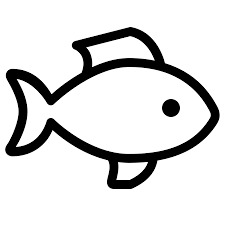

Shapes:  (225, 225, 1)


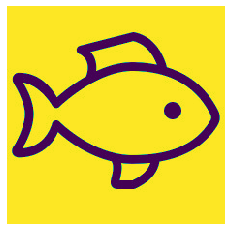

In [9]:
import numpy as np
from PIL import Image as PILImage

def display_image(image_path):
    from IPython.display import Image 
    image = Image(filename=image_path)

    display(image)

def get_image(image_path):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = PILImage.open(image_path, 'r')

    width, height = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((width, height, channels))
    return image, pixel_values

image_fname = 'fish.jpg'
display_image(image_fname)
img, pvals = get_image(image_fname)

print('Shapes: ', pvals.shape)
# redVals = pvals[:,:,0]
# greenVals = pvals[:,:,1]
# blueVals = pvals[:,:,2]
# print(redVals.shape, greenVals.shape, blueVals.shape)

out = img.point(lambda i: i * 1.0)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.axis("off")
# plt.imshow(np.asarray(img))
plt.imshow(img)
plt.show()

# print(img)
